In [1]:
#Import necessary packages and set plot types to allow interactive plots
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
#Load numpy arrays from last notebook
training_inputs = np.load('training_inputs.npy')
training_ground_truth = np.load('training_ground_truth.npy')

In [3]:
#Function to compare correlation between bottom image and images farther up in the stack
def image_correlation(image_1, image_2):
    image_1 = np.ravel(image_1)
    image_2 = np.ravel(image_2)
    
    N = image_1.shape[0]
    
    std_1 = np.std(image_1)
    std_2 = np.std(image_2)
    
    expectation_12 = np.sum(image_1*image_2)/N
    expectation_1 = np.sum(image_1)/N
    expectation_2 = np.sum(image_2)/N
    
    covariance = expectation_12 - expectation_1*expectation_2
    correlation = covariance/(std_1*std_2)
    
    #Fisher's transformation to make the correlation coefficient sampled from a normal distribution
    z_prime = 0.5*np.log((1+correlation)/(1-correlation))
    se = 1/np.sqrt(N-3)
    lower, upper = z_prime - se*1.96, z_prime + se*1.96
    
    lower, upper = np.tanh(lower), np.tanh(upper)
    
    return correlation, [lower,upper]

def z_correlation(image_stack,transformation,noise=0,plot = True):
    corr = []
    lower_ci = []
    upper_ci = []
    image = image_stack[0,0,:,:]
    mean = np.mean(image)
    std = np.std(image)
    image = (image - mean)/std
    for i in range(image_stack.shape[0]):
        altered_image = transformation(image_stack[i,0,:,:])
        mean = np.mean(altered_image)
        std = np.std(altered_image)
        altered_image = (altered_image - mean)/std
        correlation,confidence_interval = image_correlation(image,altered_image+noise)
        corr.append(correlation)
        lower_ci.append(confidence_interval[0])
        upper_ci.append(confidence_interval[1])
    if plot == True:
        _, ax = plt.subplots()
        z = range(image_stack.shape[0])
        ax.plot(z,corr,lw = 1, color = 'blue', alpha = 1, label = 'Correlation')
        ax.fill_between(z, lower_ci, upper_ci, color = 'gray', alpha = 0.4, label = '95% CI')
        ax.set_xlabel('Distance from bottom image in pixels')
        ax.set_ylabel('Correlation')
        ax.set_title('Correlation with bottom image')
        ax.legend(loc = 'best')
        plt.show()
    
    return(np.ravel(corr))

#A few simple transformations
def identity(image):
    return image

def flip_right_left(image):
    new_image = image[:,::-1]
    return new_image

def flip_up_down(image):
    new_image = image[::-1,:]
    return new_image

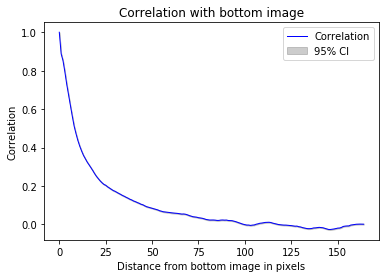

In [5]:
#Correlation drops after about 20 stacks
_ = z_correlation(training_inputs,identity)

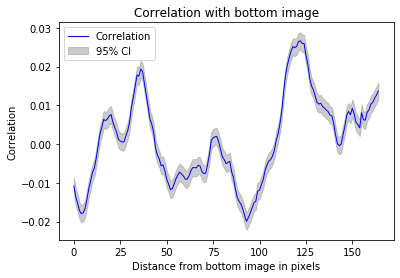

In [6]:
#Flipping left-right effectively decorrelates the images
_ = z_correlation(training_inputs,flip_right_left)

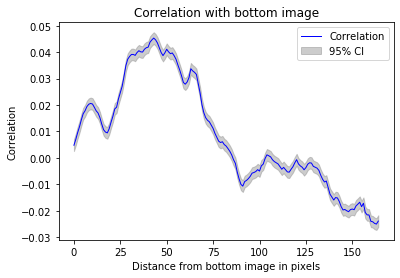

In [7]:
#flipping up-down effectively decorrelates the images
_ = z_correlation(training_inputs,flip_up_down)

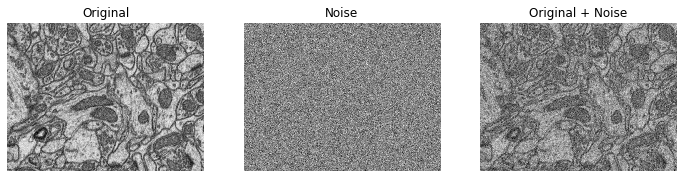

In [8]:
#Add noise to the images
image = training_inputs[0,0,:,:]
noise = np.random.normal(0,20,image.shape)

fig = plt.figure(figsize=[12,7])
ax1 = plt.subplot(1,3,1)
ax1.imshow(image,cmap='gray')
ax1.set_title('Original')
plt.gca().axis('off')
ax2 = plt.subplot(1,3,2)
ax2.imshow(noise,cmap='gray')
plt.gca().axis('off')
ax2.set_title('Noise')
ax3 = plt.subplot(1,3,3)
ax3.imshow(noise+image,cmap='gray')
ax3.set_title('Original + Noise')
plt.gca().axis('off')
plt.show()

In [9]:
#Inspect how noise intensity affects correlation of images
corr = []
noise_mags = np.linspace(0,4,5)
for noise_mag in noise_mags:
    noise = np.random.normal(0,noise_mag,training_inputs[0,0,:,:].shape)
    corr_noise = z_correlation(training_inputs,identity,noise,plot=False)
    corr.append(corr_noise)

<Figure size 864x504 with 0 Axes>

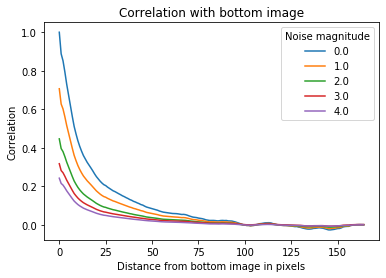

In [10]:
fig = plt.figure(figsize = [12,7])
_, ax = plt.subplots()
for i in range(len(corr)):   
    ax.plot(corr[i],label = str(noise_mags[i]))
    ax.set_xlabel('Distance from bottom image in pixels')
    ax.set_ylabel('Correlation')
    ax.set_title('Correlation with bottom image')
ax.legend(loc = 'best',title='Noise magnitude')
plt.show()

In [11]:
#Create elastic deformations
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, random_state= None):
    if random_state is None:
        random_state = np.random.RandomState(None)
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape)*2 - 1), sigma, mode = "constant",cval = 0)*alpha
    dy = gaussian_filter((random_state.rand(*shape)*2 - 1), sigma, mode = "constant",cval = 0)*alpha
    
    x,y = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))
    indices = np.reshape(y+dy,(-1,1)), np.reshape(x+dx,(-1,1))
    
    distorted_image = map_coordinates(image,indices,order=1,mode='reflect')
    return distorted_image.reshape(shape)

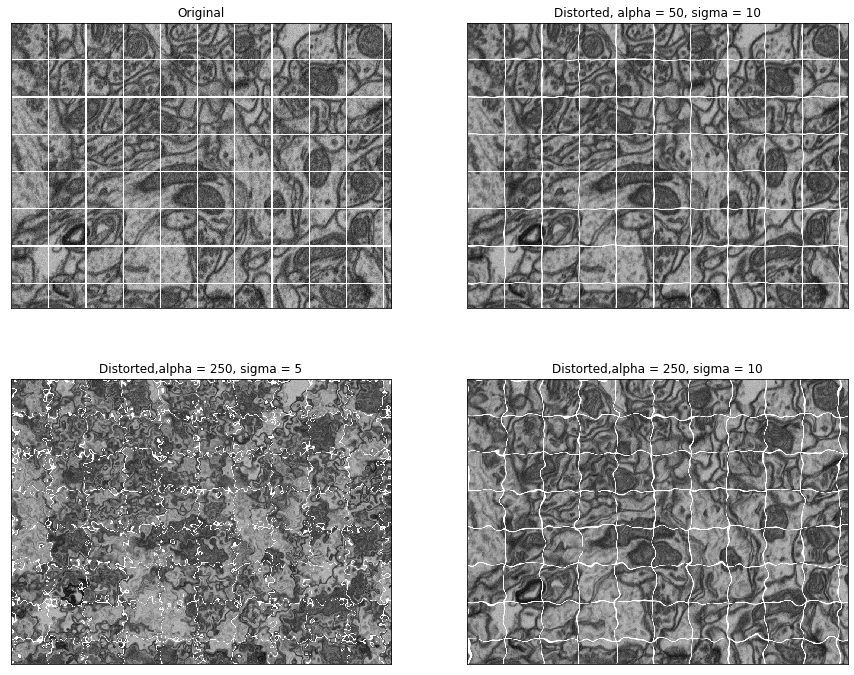

In [12]:
#Look at different parameters for image deformations
image = training_inputs[0,0,:,:]

def grid_lines(image,grid_spacing,thickness):
    shape = image.shape
    for t in range(thickness):
        image[:,t::grid_spacing] = 255
        image[t::grid_spacing,:] = 255
    return image

gridded_image = grid_lines(image,100,3)

fig = plt.figure(figsize=[15,12])
ax1 = plt.subplot(2,2,1,xticks = [],yticks=[])
ax1.imshow(gridded_image,cmap='gray')
ax1.set_title('Original')

ax2 = plt.subplot(2,2,2,xticks = [],yticks=[])
ax2.imshow(elastic_transform(gridded_image,50,10),cmap='gray')
ax2.set_title('Distorted, alpha = 50, sigma = 10')

ax3 = plt.subplot(2,2,3,xticks = [],yticks=[])
ax3.imshow(elastic_transform(gridded_image,250,5),cmap='gray')
ax3.set_title('Distorted,alpha = 250, sigma = 5')

ax4 = plt.subplot(2,2,4,xticks = [],yticks=[])
ax4.imshow(elastic_transform(gridded_image,250,10),cmap='gray')
ax4.set_title('Distorted,alpha = 250, sigma = 10')

plt.show()

In [13]:
#Investigate correlation for a specific elastic deformation
def smooth_elastic_transform(image):
    return elastic_transform(image,alpha=250,sigma=5)

corr_deform = z_correlation(training_inputs,smooth_elastic_transform,plot=False)
corr_normal = z_correlation(training_inputs,identity,plot=False)

C:\Users\Malec\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log


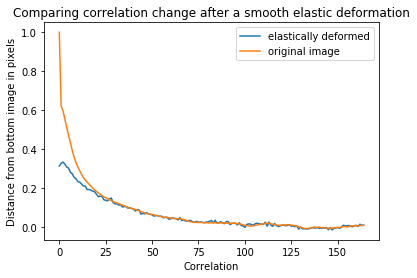

In [14]:
_,ax = plt.subplots()
ax.plot(corr_deform,label='elastically deformed')
ax.plot(corr_normal,label = 'original image')
ax.set_xlabel('Correlation')
ax.set_ylabel('Distance from bottom image in pixels')
ax.set_title('Comparing correlation change after a smooth elastic deformation')
ax.legend(loc = 'best')
plt.show()